#### Imports

In [1]:
# !pip install tensorflow==2.15.*
# !pip install keras==2.13.1
!pip install keras_ocr
!pip install mltu
!pip install albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.8/401.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.0 MB/s eta 0:00:00
  Created wheel for qqdm: filename=qqdm-0.0.7-py3-none-any.whl size=6466 sha256=09a04a1d51aa0455d5c2cccd18f170665529b1b78356345367b9d096fe7d8782
  Stored in directory: /roo

In [2]:
import tensorflow as tf
import keras

print("Keras version:", keras.__version__)
print("TensorFlow version:", tf.__version__)

Keras version: 3.3.3
TensorFlow version: 2.16.1


In [3]:
import matplotlib.pyplot as plt
import keras_ocr

In [4]:
import os
import random
import numpy as np
from zipfile import ZipFile
from PIL import Image
import json
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Bidirectional, LSTM, Reshape, Lambda, StringLookup, Conv2D, BatchNormalization, MaxPooling2D, Reshape, Bidirectional, LSTM, Dropout, Dense, Reshape
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences

from mltu.tensorflow.model_utils import residual_block
from mltu.tensorflow.losses import CTCloss
from mltu.tensorflow.metrics import CWERMetric
from mltu.utils.text_utils import ctc_decoder

In [5]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Directories

In [6]:
ROOT_DIR = os.getcwd()
DATASET_DIR = '/kaggle/input/ocr-test'
EXTRA_DATASET_DIR = '/kaggle/input/extra-dataset'

TRAIN_DIR = os.path.join(DATASET_DIR, "train", "train")
EXTRA_TRAIN_DIR = os.path.join(EXTRA_DATASET_DIR, 'dataset_tambahan', 'train')
VAL_DIR = os.path.join(DATASET_DIR, "test", "test")
EXTRA_VAL_DIR = os.path.join(EXTRA_DATASET_DIR, 'dataset_tambahan', 'val')

EXTRA_TRAIN_METADATA_PATH = os.path.join(EXTRA_DATASET_DIR, 'dataset_tambahan',  'train', "result.jsonl")
TRAIN_METADATA_PATH = os.path.join(TRAIN_DIR, "metadata.jsonl")
VAL_METADATA_PATH = os.path.join(VAL_DIR, "metadata.jsonl")
EXTRA_VAL_METADATA_PATH = os.path.join(EXTRA_DATASET_DIR, 'dataset_tambahan', 'val', "result.jsonl")

PRETRAINED_MODEL_PATH = '/kaggle/input/ocr120/keras/default/1/keras_ocr_model.keras'
PRETRAINED_WEIGHTS_PATH = '/kaggle/input/weight120epoch/keras/default/1/weights.h5'
TRAINED_MODEL_PATH = os.path.join("trained_models")

In [7]:
print(len(os.listdir(TRAIN_DIR)))
print(len(os.listdir(VAL_DIR)))

33627
18705


#### Params

In [8]:
BATCH_SIZE = 64
IMAGE_SIZE = (31, 300)
BUFFER_SIZE = 1000
LEARNING_RATE = 0.0001

BUILD_PARAMS = {
    "height": IMAGE_SIZE[0],
    "width": IMAGE_SIZE[1],
    "color": False,
    "filters": (64, 128, 256, 256, 512, 512, 512),
    "rnn_units": (128, 128),
    "dropout": 0.25,
    "rnn_steps_to_discard": 2,
    "pool_size": 2,
    "stn": False,
}

In [9]:
def load_json_data(file_path):
    image_data = []
    text_data = []
    with open(file_path, 'r') as file:
        for line in file:
            try:
                data = json.loads(line.strip())
                image_data.append(data['file_name'])
                text_data.append(data['text'])
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
    
    return image_data, text_data

#### Preprocessing Images

In [10]:
def preprocess_image(image_path, target_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image.set_shape([None, None, 3])  # Ensure the shape is defined
    image = tf.image.resize(image, target_size)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.cast(image, tf.int32)
    return image

def load_images_as_tensor(data_json, image_size, subset):
    dataset = tf.data.Dataset.from_tensor_slices(data_json)
 
    if subset == "train":
        preprocess_fn = lambda img: preprocess_image(
            tf.strings.join([TRAIN_DIR, img], separator=os.path.sep), image_size
        )
    elif subset == "val":
        preprocess_fn = lambda img: preprocess_image(
            tf.strings.join([VAL_DIR, img], separator=os.path.sep), image_size
        )
    elif subset == "extra_train":
        preprocess_fn = lambda img: preprocess_image(
            tf.strings.join([EXTRA_TRAIN_DIR, img], separator=os.path.sep), image_size
        )
    elif subset == "extra_val":
        preprocess_fn = lambda img: preprocess_image(
            tf.strings.join([EXTRA_VAL_DIR, img], separator=os.path.sep), image_size
        )
        
    

    dataset = dataset.map(
        preprocess_fn,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    return dataset

In [11]:
extra_train_image_data, extra_train_text_data = load_json_data(EXTRA_TRAIN_METADATA_PATH)
train_image_data, train_text_data = load_json_data(TRAIN_METADATA_PATH)
extra_val_image_data, extra_val_text_data = load_json_data(EXTRA_VAL_METADATA_PATH)
val_image_data, val_text_data = load_json_data(VAL_METADATA_PATH)

In [12]:
print(len(train_image_data))
print(len(extra_train_image_data))

33626
1712


#### Vectorizer Settings

In [13]:
char_set = list('0123456789abcdefghijklmnopqrstuvwxyz.,!?@$&()[]{}:;/- ')

max_len_text_t = max(train_text_data, key=len)
max_len_t = len(max_len_text_t)

max_len_text = max(val_text_data, key=len)
max_len = len(max_len_text)

vocab_size = len(char_set) + 2

print(f"Vocab size: {vocab_size}")
print(f"Maximum raw text length val: {max_len}")
print(f"Maximum raw text length train: {max_len_t}")

char_to_num = StringLookup(
    vocabulary = list(char_set),
    mask_token = None
)

num_to_char = StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None, 
    invert = True
)

Vocab size: 56
Maximum raw text length val: 69
Maximum raw text length train: 68


#### Preprocessing Texts

In [14]:
def preprocess_text(text, pad_max_len, pad_value):
    #print(f"tokenized_text: length: {tf.strings.length(tokenized_text).numpy()}")
    lower_text = tf.strings.lower(text)
    split_text = tf.strings.unicode_split(lower_text, input_encoding='UTF-8') 
    #print(f"tokenized_text splitted with tf.strings: length: {tf.size(split_text).numpy()}") 
    vectorized_text = char_to_num(split_text)
    padded_text = tf.pad(vectorized_text, paddings=[[0, pad_max_len - tf.size(vectorized_text)]], constant_values=pad_value)
    return padded_text

def text_decoder(tokenized_text, pad_value):
    decoded_text = num_to_char(tokenized_text)
    decoded_text = tf.where(tokenized_text == pad_value, '', decoded_text)
    decoded_text = tf.strings.reduce_join(decoded_text, axis=-1, separator='')
    return decoded_text.numpy().decode('utf-8')

def load_text_to_tensor(data_text_json, pad_max_len, pad_value):
    dataset = tf.data.Dataset.from_tensor_slices(data_text_json)
    dataset = dataset.map(
        lambda text: preprocess_text(text, pad_max_len, pad_value),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    return dataset

#### Creating The Dataset

In [15]:
import albumentations as A
import tensorflow as tf
import numpy as np

albumentations_augmentation = A.Compose([        
    A.RandomBrightnessContrast(brightness_limit=0.4, p=0.1),    
    A.GridDistortion(num_steps=10, distort_limit=(-0.4, 0.4), p=0.3),
    A.Affine(translate_percent=0, rotate=0.1, shear=0.2, p=1),
    A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, p=0.3),
    A.GaussNoise(var_limit=(0, 99), p=0.3),
    A.ElasticTransform(alpha=7, sigma=5, p=0.3),
    A.Morphological(scale=(1,5), p=0.3),
    A.Resize(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1])           
])

def albumentations_augment(image, label, repeat=3):
    image = image.numpy().astype(np.uint8)
    label = label.numpy()
    
    augmented_images = []
    augmented_labels = []
    
    for _ in range(repeat):
        # Apply augmentation
        augmented = albumentations_augmentation(image=image)
        augmented_image = augmented['image']
        
        # Convert back to tensor
        augmented_image = tf.convert_to_tensor(augmented_image, dtype=tf.float32)
        augmented_label = tf.convert_to_tensor(label, dtype=tf.int64)
        
        augmented_images.append(augmented_image)
        augmented_labels.append(augmented_label)
    
    # Stack augmented images and labels
    augmented_images_tensor = tf.stack(augmented_images)
    augmented_labels_tensor = tf.stack(augmented_labels)
    
    return augmented_images_tensor, augmented_labels_tensor

def tf_albumentations_augment(image, label, repeat=1):
    augmented_images, augmented_labels = tf.py_function(
        func=albumentations_augment, 
        inp=[image, label, repeat], 
        Tout=[tf.float32, tf.int64]
    )
    
    augmented_images.set_shape([repeat, IMAGE_SIZE[0], IMAGE_SIZE[1], 1])
    augmented_labels.set_shape([repeat, max_len])
    
    return augmented_images, augmented_labels

def apply_augmentation(dataset, repeat=1):
    return dataset.map(
        lambda image, label: tf_albumentations_augment(image, label, repeat),
        num_parallel_calls=tf.data.AUTOTUNE
    ).unbatch()

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


#### Image Augmentation

In [16]:
# def load_dataset(data_path, subset, image_size, pad_max_len, pad_value, add_extra=False) :    
#     images, texts = load_json_data(data_path)
#     images_t = load_images_as_tensor(images, image_size, subset)
#     texts_t = load_text_to_tensor(texts, pad_max_len, pad_value)
    
#     # dataset = tf.data.Dataset.zip((images_t, texts_t))
#     # augmented_dataset = apply_augmentation(dataset, repeat=1)

#     if add_extra:
#         if subset == "train":
#             ex_images, ex_texts = load_json_data(EXTRA_TRAIN_METADATA_PATH)
#         else:
#             ex_images, ex_texts = load_json_data(EXTRA_VAL_METADATA_PATH)
            
#         ex_images_t = load_images_as_tensor(ex_images, image_size, f'extra_{subset}')
#         ex_texts_t = load_text_to_tensor(ex_texts, pad_max_len, pad_value)
#         ex_dataset = tf.data.Dataset.zip((ex_images_t, ex_texts_t))
#         ex_augmented_dataset = apply_augmentation(ex_dataset, 1)
#         augmented_dataset = augmented_dataset.concatenate(ex_augmented_dataset)
        
#     final_dataset = (augmented_dataset
#          .shuffle(buffer_size=BUFFER_SIZE)
#          .cache()
#          .batch(batch_size=BATCH_SIZE)
#          .prefetch(buffer_size=tf.data.AUTOTUNE)
#      )
#     return final_dataset


def load_dataset(data_path, subset, image_size, pad_max_len, pad_value, add_extra=False):    
    images, texts = load_json_data(data_path)
    images_t = load_images_as_tensor(images, image_size, subset)
    texts_t = load_text_to_tensor(texts, pad_max_len, pad_value)
    
    dataset = tf.data.Dataset.zip((images_t, texts_t))

    if add_extra:
        if subset == "train":
            ex_images, ex_texts = load_json_data(EXTRA_TRAIN_METADATA_PATH)
        else:
            ex_images, ex_texts = load_json_data(EXTRA_VAL_METADATA_PATH)
            
        ex_images_t = load_images_as_tensor(ex_images, image_size, f'extra_{subset}')
        ex_texts_t = load_text_to_tensor(ex_texts, pad_max_len, pad_value)
        ex_dataset = tf.data.Dataset.zip((ex_images_t, ex_texts_t))
        dataset = dataset.concatenate(ex_dataset)
        
    final_dataset = (dataset
         .shuffle(buffer_size=BUFFER_SIZE)
         .cache()
         .batch(batch_size=BATCH_SIZE)
         .prefetch(buffer_size=tf.data.AUTOTUNE)
     )
    return final_dataset

In [17]:
train_ds = load_dataset(TRAIN_METADATA_PATH, "train", IMAGE_SIZE, max_len, vocab_size, add_extra=True)
val_ds = load_dataset(VAL_METADATA_PATH, "val", IMAGE_SIZE, max_len, vocab_size, add_extra=True)

train_cardinality = train_ds.cardinality().numpy()
val_cardinality = val_ds.cardinality().numpy()

print(f"Train dataset total data: {train_cardinality * BATCH_SIZE}")
print(f"Validation dataset total data: {val_cardinality * BATCH_SIZE}")

Train dataset total data: 35392
Validation dataset total data: 18880


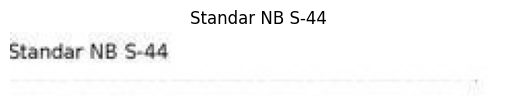

15
15
tf.Tensor(
[29 30 11 24 14 11 28 54 24 12 54 29 53  5  5 56 56 56 56 56 56 56 56 56
 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56
 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56], shape=(69,), dtype=int64)
standar nb s-44


In [18]:
image_error = extra_train_image_data[827]
text_error = extra_train_text_data[827]
image_path = os.path.join(EXTRA_TRAIN_DIR, image_error)
image = Image.open(image_path)

plt.imshow(image)
plt.axis('off') 
plt.title(text_error)
plt.show()

print(len(text_error))
print(len(char_to_num(list(text_error))))
test = preprocess_text(text_error, max_len, vocab_size)
print(test)
print(text_decoder(test, vocab_size))

#BROKEN IMAGE index: 827, 214, 419

In [19]:
# for x in range(len(extra_train_image_data)):

#     # if x == 827:
#     #     continue
    
#     image_error = extra_train_image_data[x]
#     text_error = extra_train_text_data[x]
#     image_path = os.path.join(TRAIN_DIR, image_error)
#     #image = Image.open(image_path)

#     # plt.imshow(image)
#     # plt.axis('off') 
#     # plt.title(text_error)
#     # plt.show()
    
#     print(f"image index: {x}")
#     print(f"text len: {len(text_error)}")
#    # print(len(char_to_num(list(text_error))))
#     test = preprocess_text(text_error, max_len, vocab_size)
#     print(test)
#     print(text_decoder(test, vocab_size))

In [20]:
for image, text in train_ds.take(1):
    sample_text = text[0]
    print(f"image shape: {image.shape}")
    print(f"text shape: {text.shape}")
    print(sample_text)
    print(text_decoder(sample_text, vocab_size))


image shape: (64, 31, 300, 1)
text shape: (64, 69)
tf.Tensor(
[27 30 35 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56
 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56
 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56 56], shape=(69,), dtype=int64)
qty


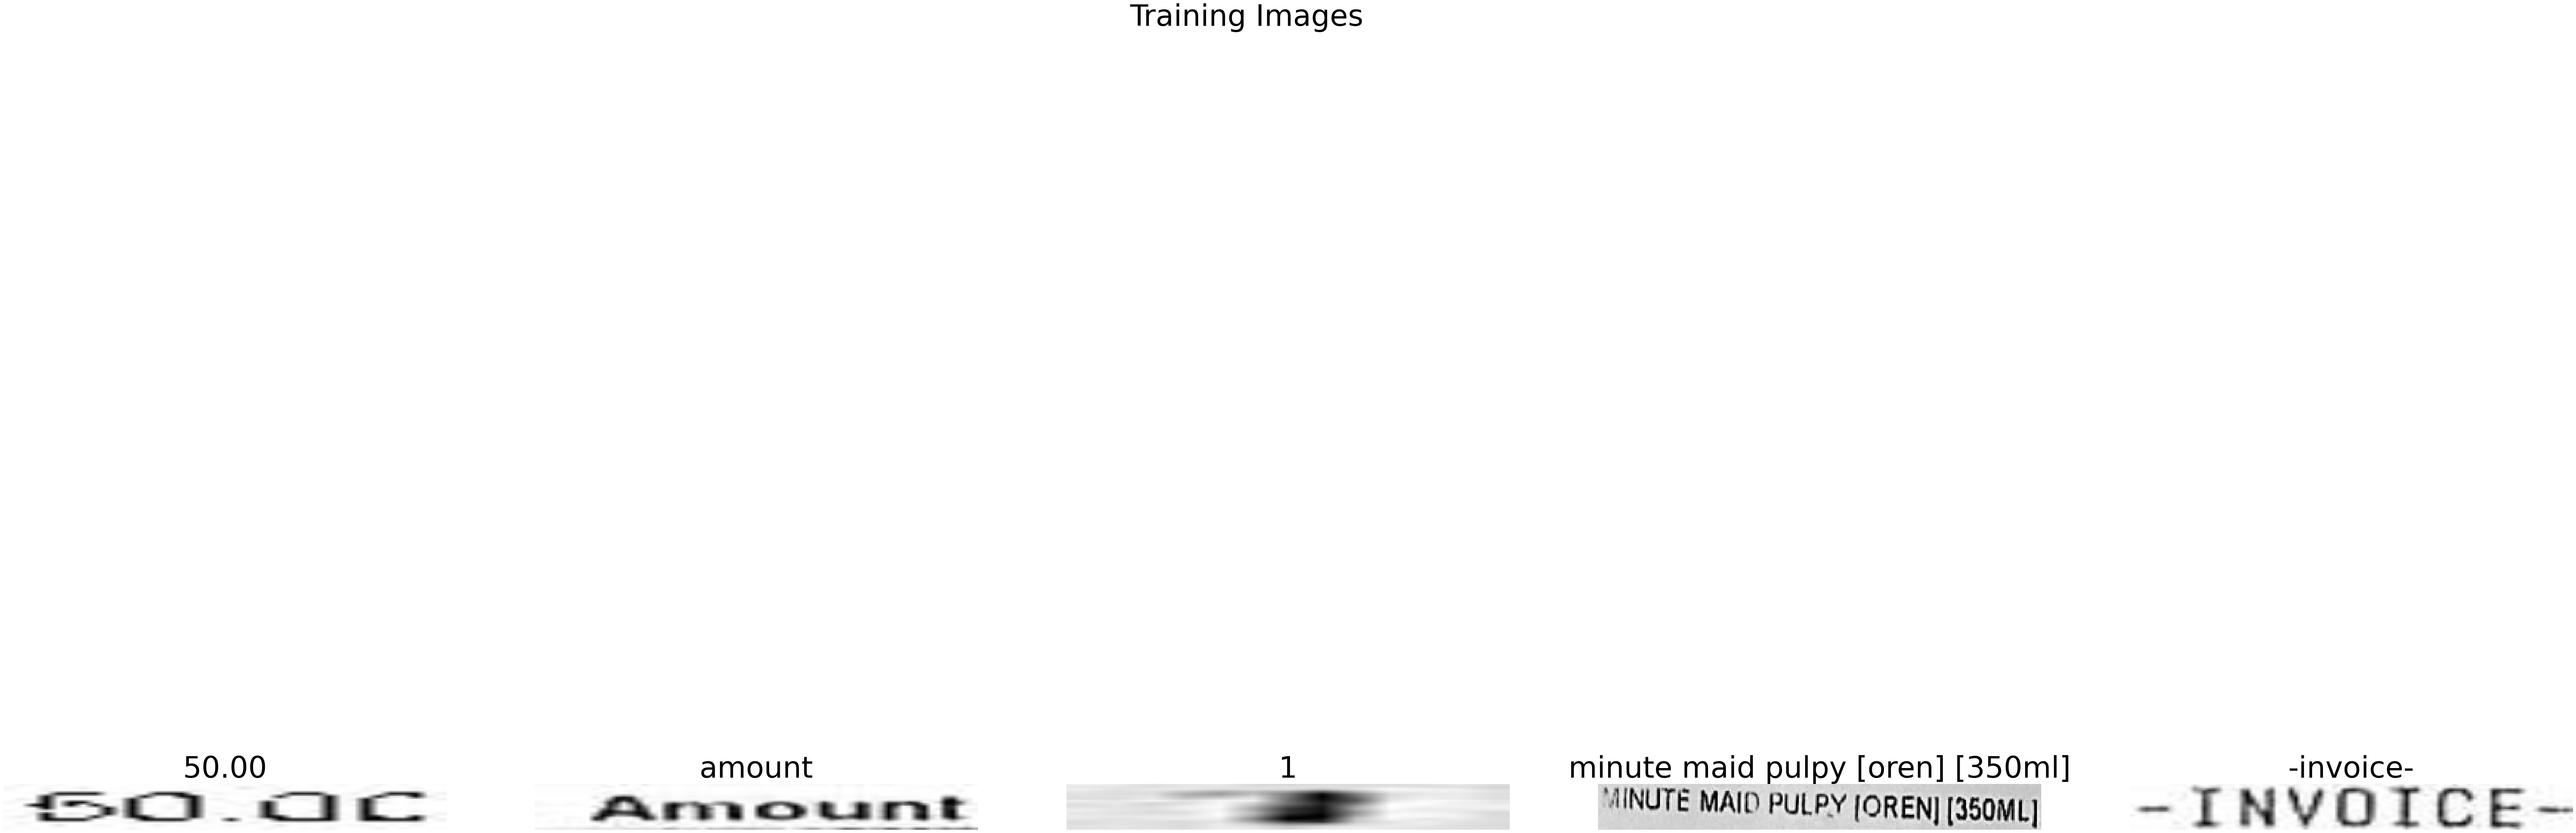

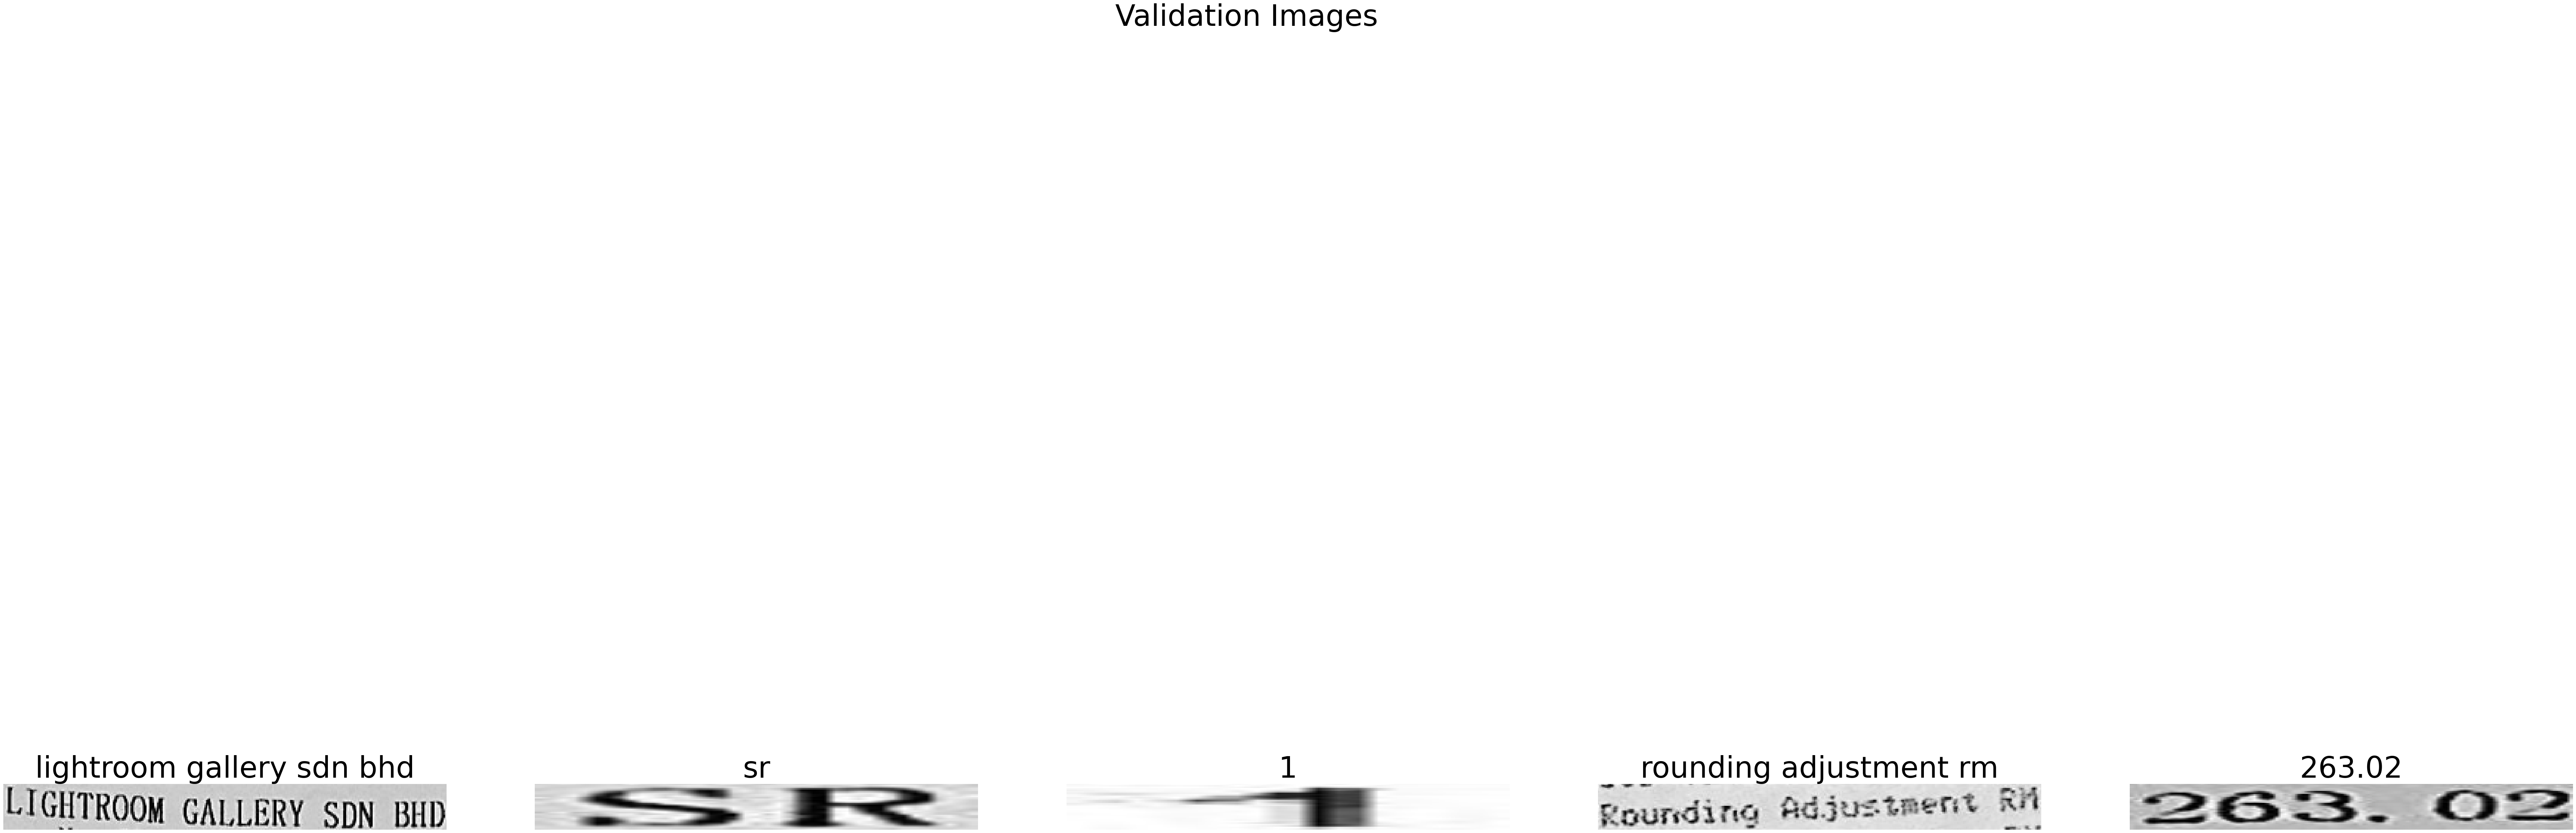

In [21]:
def plot_images_with_titles(dataset, num_images, title="Images", figsize=(100, 50), font_size=64):
    fig, axes = plt.subplots(1, num_images, figsize=figsize)

    for idx, (image, text) in enumerate(dataset.take(1)):
        if idx >= num_images:
            break

        for i in range(min(num_images, image.shape[0])):  
            single_img = image[i]  
            single_text = text[i]
            text_title = text_decoder(single_text, vocab_size) 
            axes[i].imshow(single_img.numpy().squeeze(), cmap='gray')
            axes[i].set_title(text_title, fontsize=font_size) 
            axes[i].axis('off')

    plt.suptitle(title, fontsize=font_size)
    plt.show()


plot_images_with_titles(train_ds, num_images=5, title="Training Images")
plot_images_with_titles(val_ds, num_images=5, title="Validation Images")

#### Creating Model

In [22]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input

def load_pretrained_model(vocab_size, **kwargs):
    height = kwargs.get("height")
    width = kwargs.get("width")
    color = kwargs.get("color", False)
    filters = kwargs.get("filters")
    rnn_units = kwargs.get("rnn_units")
    pool_size = kwargs.get("pool_size")
    
    assert len(filters) == 7, "7 CNN filters must be provided."
    assert len(rnn_units) == 2, "2 RNN units must be provided."

    # Input layer
    inputs = Input(shape=(height, width, 3 if color else 1), name="input_image")

    # Image normalization (scaling pixel values to the range [0, 1])
    x = layers.Lambda(lambda x: x / 255.0, name="image_normalization")(inputs)

    # Backbone (Convolutional layers)
    x = layers.Permute((2, 1, 3))(x)  # Swap width and height
    x = layers.Conv2D(filters[0], (3, 3), activation="relu", padding="same", name="conv_1")(x)
    x = layers.Conv2D(filters[1], (3, 3), activation="relu", padding="same", name="conv_2")(x)
    x = layers.Conv2D(filters[2], (3, 3), activation="relu", padding="same", name="conv_3")(x)
    x = layers.BatchNormalization(name="bn_3")(x)
    x = layers.MaxPooling2D(pool_size=(pool_size, pool_size), name="maxpool_3")(x)

    x = layers.Conv2D(filters[3], (3, 3), activation="relu", padding="same", name="conv_4")(x)
    x = layers.Conv2D(filters[4], (3, 3), activation="relu", padding="same", name="conv_5")(x)
    x = layers.BatchNormalization(name="bn_5")(x)
    x = layers.MaxPooling2D(pool_size=(pool_size, pool_size), name="maxpool_5")(x)

    x = layers.Conv2D(filters[5], (3, 3), activation="relu", padding="same", name="conv_6")(x)
    x = layers.Conv2D(filters[6], (3, 3), activation="relu", padding="same", name="conv_7")(x)
    x = layers.BatchNormalization(name="bn_7")(x)

    # Reshape for RNN layers
    x = layers.Reshape(
        target_shape=(
            width // pool_size**2,
            (height // pool_size**2) * filters[-1],
        )
   ,name="reshape")(x)

    x = keras.layers.Dense(rnn_units[0], activation="relu", name="fc_9")(x)

    # First RNN layer
    rnn_1_forward = layers.LSTM(
        rnn_units[0],
        return_sequences=True,
        kernel_initializer="he_normal",
        name="lstm_10"
    )(x)
    rnn_1_backward = layers.LSTM(
        rnn_units[0],
        return_sequences=True,
        kernel_initializer="he_normal",
        go_backwards=True,
        name="lstm_10_back"
    )(x)
    rnn_1 = layers.Add()([rnn_1_forward, rnn_1_backward])

    # Second RNN layer
    rnn_2_forward = layers.LSTM(
        rnn_units[1], return_sequences=True, kernel_initializer="he_normal", name="lstm_11"
    )(rnn_1)
    rnn_2_backward = layers.LSTM(
        rnn_units[1],
        return_sequences=True,
        kernel_initializer="he_normal",
        go_backwards=True,
        name="lstm_11_back"
    )(rnn_1)
    x = layers.Concatenate()([rnn_2_forward, rnn_2_backward])

    # Dense layer for classification
    output = layers.Dense(
        vocab_size + 1,  # +1 for the CTC blank token
        activation="softmax",
        name="fc_12",
    )(x)

    # Model definition
    model = models.Model(inputs=inputs, outputs=output, name="keras_ocr_model")

    return model


In [23]:
# def load_crnn_model(input_dim, output_dim, activation='relu', dropout=0.3):
#     inputs = Input(shape=input_dim, name="input")
#     inputs_normalized = Lambda(lambda x: x / 255.0)(inputs)  # Normalizing input to [0, 1]
    
#     c_1 = Conv2D(32, (3, 3), activation=activation, padding='same', name='conv_1')(inputs_normalized)
#     c_2 = Conv2D(32, (3, 3), activation=activation, padding='same', name='conv_2')(c_1)
#     c_3 = Conv2D(64, (3, 3), activation=activation, padding='same', name='conv_3')(c_2)
#     bn_3 = BatchNormalization(name='bn_3')(c_3)
#     p_3 = MaxPooling2D(pool_size=(2, 2), name='maxpool_3')(bn_3)

#     c_4 = Conv2D(64, (3, 3), activation=activation, padding='same', name='conv_4')(p_3)
#     c_5 = Conv2D(64, (3, 3), activation=activation, padding='same', name='conv_5')(c_4)
#     bn_5 = BatchNormalization(name='bn_5')(c_5)
#     p_5 = MaxPooling2D(pool_size=(2, 2), name='maxpool_5')(bn_5)

#     c_6 = Conv2D(128, (3, 3), activation=activation, padding='same', name='conv_6')(p_5)
#     c_7 = Conv2D(128, (3, 3), activation=activation, padding='same', name='conv_7')(c_6)
#     bn_7 = BatchNormalization(name='bn_7')(c_7)

#     reshaped_output = Reshape((bn_7.shape[1] * bn_7.shape[2], bn_7.shape[-1]))(bn_7)
    
#     # Add Bidirectional LSTM layers to capture sequential patterns
#     blstm_8 = Bidirectional(LSTM(32, kernel_initializer="he_normal", return_sequences=True))(reshaped_output)
#     blstm_8 = Bidirectional(LSTM(64, kernel_initializer="he_normal", return_sequences=True))(reshaped_output)
#     do_10 = Dropout(dropout, name='dropout')(blstm_8)
    
#     output = Dense(output_dim + 1, activation='softmax', name="output")(do_10)

#     # Create and return the model
#     model = Model(inputs=inputs, outputs=output)
#     return model

#### CTC Loss and CWER Metrics

In [24]:
class CTCloss(tf.keras.losses.Loss):
    """ CTCLoss object for training the model """
    def __init__(self, reduction=tf.keras.losses.Reduction.AUTO, name: str = "CTCloss") -> None:
        super(CTCloss, self).__init__(name=name)
        self.reduction = reduction
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def __call__(self, y_true: tf.Tensor, y_pred: tf.Tensor, sample_weight=None) -> tf.Tensor:
        """ Compute the training batch CTC loss value """
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        # Calculate CTC loss using the built-in ctc_batch_cost function
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)

        # Apply reduction (if necessary)
        if self.reduction == tf.keras.losses.Reduction.NONE:
            return loss
        elif self.reduction == tf.keras.losses.Reduction.SUM:
            return tf.reduce_sum(loss)
        elif self.reduction == tf.keras.losses.Reduction.AUTO:
            return tf.reduce_mean(loss)
        else:
            return loss  

class CWERMetric(tf.keras.metrics.Metric):
    """A custom TensorFlow metric to compute the Character Error Rate (CER).
    
    Args:
        padding_token: An integer representing the padding token in the input data.
        name: (Optional) string name of the metric instance.
        **kwargs: Additional keyword arguments.
    """
    def __init__(self, padding_token=0, name="CWER", **kwargs):
        # Initialize the base Metric class
        super(CWERMetric, self).__init__(name=name, **kwargs)
        
        # Initialize variables to keep track of the cumulative character/word error rates and counter
        self.cer_accumulator = tf.Variable(0.0, name="cer_accumulator", dtype=tf.float32)
        self.wer_accumulator = tf.Variable(0.0, name="wer_accumulator", dtype=tf.float32)
        self.batch_counter = tf.Variable(0, name="batch_counter", dtype=tf.int32)
        
        # Store the padding token as an attribute
        self.padding_token = padding_token

    def update_state(self, y_true, y_pred, sample_weight=None):
        """Updates the state variables of the metric.

        Args:
            y_true: A tensor of true labels with shape (batch_size, sequence_length).
            y_pred: A tensor of predicted labels with shape (batch_size, sequence_length, num_classes).
            sample_weight: (Optional) a tensor of weights with shape (batch_size, sequence_length).
        """
        # Get the input shape and length
        input_shape = tf.keras.backend.shape(y_pred)
        input_length = tf.ones(shape=input_shape[0], dtype="int32") * tf.cast(input_shape[1], "int32")

        # Decode the predicted labels using greedy decoding
        decode_predicted, log = tf.keras.backend.ctc_decode(y_pred, input_length, greedy=True)

        # Convert the dense decode tensor to a sparse tensor
        predicted_labels_sparse = tf.keras.backend.ctc_label_dense_to_sparse(decode_predicted[0], input_length)
        
        # Convert the dense true labels tensor to a sparse tensor and cast to int64
        true_labels_sparse = tf.cast(tf.keras.backend.ctc_label_dense_to_sparse(y_true, input_length), "int64")

        # Retain only the non-padding elements in the predicted labels tensor
        predicted_labels_sparse = tf.sparse.retain(predicted_labels_sparse, tf.not_equal(predicted_labels_sparse.values, -1))
        
        # Retain only the non-padding elements in the true labels tensor
        true_labels_sparse = tf.sparse.retain(true_labels_sparse, tf.not_equal(true_labels_sparse.values, self.padding_token))

        # Calculate the normalized edit distance between the predicted labels and true labels tensors
        distance = tf.edit_distance(predicted_labels_sparse, true_labels_sparse, normalize=True)

        # Add the sum of the distance tensor to the cer_accumulator variable
        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        
        # Increment the batch_counter by the batch size
        self.batch_counter.assign_add(input_shape[0])

        # Calculate the number of wrong words in batch and add to wer_accumulator variable
        self.wer_accumulator.assign_add(tf.reduce_sum(tf.cast(tf.not_equal(distance, 0), tf.float32)))

    def result(self):
        """Computes and returns the metric result.

        Returns:
            A dictionary containing the CER and WER.
        """
        return {
                "CER": tf.math.divide_no_nan(self.cer_accumulator, tf.cast(self.batch_counter, tf.float32)),
                "WER": tf.math.divide_no_nan(self.wer_accumulator, tf.cast(self.batch_counter, tf.float32))
        }

#### Training the model

In [25]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

print(vocab_size)

model = load_pretrained_model(vocab_size, **BUILD_PARAMS)
# model = tf.keras.models.load_model(PRETRAINED_MODEL_PATH, safe_mode=False, custom_objects={'CTCloss': CTCloss, 'CWERMetric': CWERMetric})
# print(PRETRAINED_WEIGHTS_PATH)
model.load_weights(PRETRAINED_WEIGHTS_PATH)

model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), 
    loss=CTCloss(), 
    metrics=[CWERMetric(padding_token=vocab_size)],
    run_eagerly=False
)

earlystopper = EarlyStopping(monitor="val_CER", patience=50, verbose=1, mode='min')
#checkpoint = ModelCheckpoint(f"{TRAINED_MODEL_PATH}/{model.name}/weight/best_weight.keras", monitor="val_CER", verbose=1, save_best_only=True, mode="min")
tb_callback = TensorBoard(f"{TRAINED_MODEL_PATH}/{model.name}/log/logs", update_freq=10)
reduceLROnPlat = ReduceLROnPlateau(monitor="val_CER", factor=0.9, min_delta=1e-10, patience=5, verbose=1, mode="auto")

model.summary()

56


Model: "keras_ocr_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 31, 300,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_normalization │ (None, 31, 300,   │          0 │ input_image[0][0] │
│ (Lambda)            │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 300, 31,   │          0 │ image_normalizat… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, 300, 31,   │        640 │ permute[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv2D)     │ (None, 300, 31,   │     73,856 │ conv_1[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv2D)     │ (None, 300, 31,   │    295,168 │ conv_2[0][0]      │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_3                │ (None, 300, 31,   │      1,024 │ conv_3[0][0]      │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool_3           │ (None, 150, 15,   │          0 │ bn_3[0][0]        │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_4 (Conv2D)     │ (None, 150, 15,   │    590,080 │ maxpool_3[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_5 (Conv2D)     │ (None, 150, 15,   │  1,180,160 │ conv_4[0][0]      │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_5                │ (None, 150, 15,   │      2,048 │ conv_5[0][0]      │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool_5           │ (None, 75, 7,     │          0 │ bn_5[0][0]        │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_6 (Conv2D)     │ (None, 75, 7,     │  2,359,808 │ maxpool_5[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_7 (Conv2D)     │ (None, 75, 7,     │  2,359,808 │ conv_6[0][0]      │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_7                │ (None, 75, 7,     │      2,048 │ conv_7[0][0]      │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 75, 3584)  │          0 │ bn_7[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc_9 (Dense)        │ (None, 75, 128)   │    458,880 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,864,505 (30.00 MB)

 Trainable params: 7,861,945 (29.99 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [26]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=150,
    callbacks=[earlystopper, reduceLROnPlat, tb_callback],
)

Epoch 1/150
553/553 ━━━━━━━━━━━━━━━━━━━━ 522s 916ms/step - CER: 0.0011 - WER: 0.0077 - loss: inf - val_CER: 0.0148 - val_WER: 0.0710 - val_loss: 2.5337 - learning_rate: 1.0000e-04
Epoch 2/150
553/553 ━━━━━━━━━━━━━━━━━━━━ 267s 484ms/step - CER: 0.0117 - WER: 0.0578 - loss: inf - val_CER: 0.0144 - val_WER: 0.0687 - val_loss: 2.3708 - learning_rate: 1.0000e-04
Epoch 3/150
553/553 ━━━━━━━━━━━━━━━━━━━━ 267s 484ms/step - CER: 0.0126 - WER: 0.0608 - loss: inf - val_CER: 0.0140 - val_WER: 0.0664 - val_loss: 2.3413 - learning_rate: 1.0000e-04
Epoch 4/150
553/553 ━━━━━━━━━━━━━━━━━━━━ 267s 482ms/step - CER: 0.0129 - WER: 0.0613 - loss: inf - val_CER: 0.0140 - val_WER: 0.0656 - val_loss: 2.2928 - learning_rate: 1.0000e-04
Epoch 5/150
553/553 ━━━━━━━━━━━━━━━━━━━━ 267s 482ms/step - CER: 0.0130 - WER: 0.0612 - loss: inf - val_CER: 0.0139 - val_WER: 0.0646 - val_loss: 2.3165 - learning_rate: 1.0000e-04
Epoch 6/150
553/553 ━━━━━━━━━━━━━━━━━━━━ 268s 484ms/step - CER: 0.0132 - WER: 0.0609 - loss: inf - v

#### METRICS (CER) AND (WER)

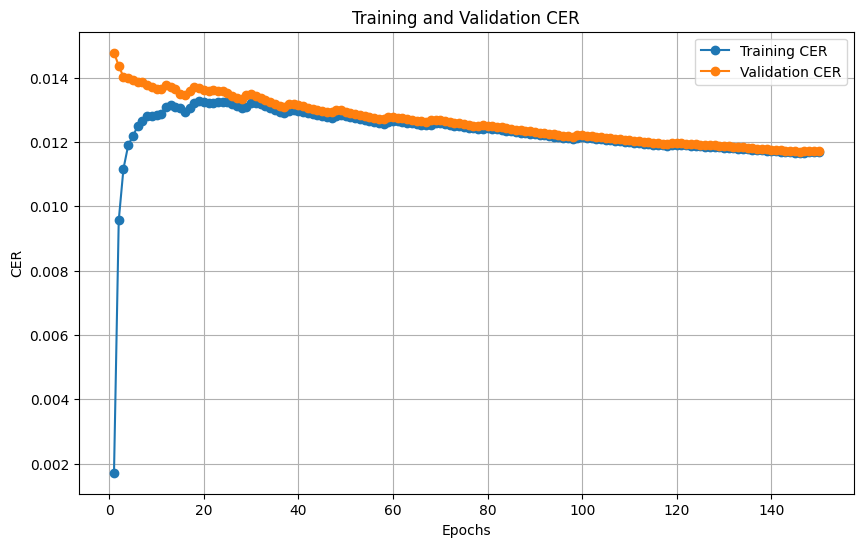

In [27]:
train_cer = history.history['CER']
val_cer = history.history['val_CER']
epochs = list(range(1, len(train_cer) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_cer, label='Training CER', marker='o')
plt.plot(epochs, val_cer, label='Validation CER', marker='o')
plt.title('Training and Validation CER')
plt.xlabel('Epochs')
plt.ylabel('CER')
plt.legend()
plt.grid()
plt.show()

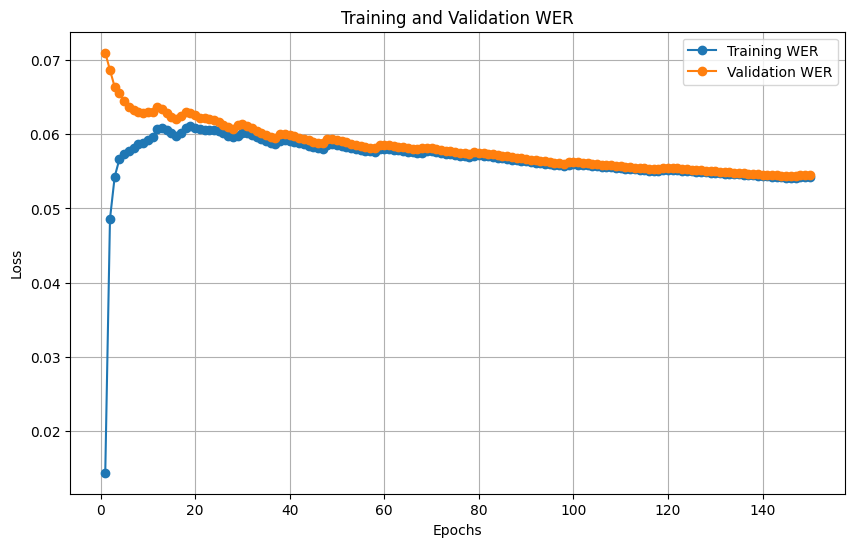

In [28]:
train_wer = history.history['WER']
val_wer = history.history['val_WER']
epochs = list(range(1, len(train_wer) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_wer, label='Training WER', marker='o')
plt.plot(epochs, val_wer, label='Validation WER', marker='o')
plt.title('Training and Validation WER')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

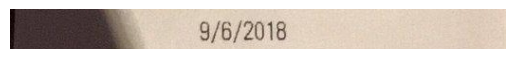

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
 9/6/2018


In [29]:
example_image = extra_val_image_data[74]
image_path = os.path.join(EXTRA_VAL_DIR, example_image)
image = Image.open(image_path)

# Plot the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

pre_image = preprocess_image(image_path, IMAGE_SIZE)
pre_image = tf.expand_dims(pre_image, axis=0)

predictions = model.predict(pre_image)
resulted_text = ctc_decoder(predictions, char_to_num.get_vocabulary())[0]
print(resulted_text)

#### Save Model

In [30]:
import os
import shutil
from IPython.display import FileLink

model_save_path = os.path.join(TRAINED_MODEL_PATH, model.name, 'model')
os.makedirs(model_save_path, exist_ok=True)
model.save(os.path.join(model_save_path, f"{model.name}.keras"))
model.save_weights(os.path.join(model_save_path, "best.weights.h5"))

zip_path = os.path.join(TRAINED_MODEL_PATH, model.name)
full_zip_path = os.path.join(zip_path, f"{model.name}.zip")
shutil.make_archive(zip_path, 'zip', TRAINED_MODEL_PATH)

# Display a download link
print(f"Zipped model is available for download at: {zip_path}")

Zipped model is available for download at: trained_models/keras_ocr_model


In [31]:
FileLink(os.path.join(TRAINED_MODEL_PATH, f"{model.name}.zip"))

/kaggle/working/trained_models/keras_ocr_model.zip